In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

<IPython.core.display.Javascript object>

In [9]:
%matplotlib inline
import os
import random
import sys
from pathlib import Path

import cv2
import numpy as np
from matplotlib import pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.dpi"] = 100  # 200 e.g. is really fine, but slower

In [10]:
base_path = Path(os.getcwd()).parent.parent
sys.path.append(base_path.as_posix())

In [11]:
%%capture

import argparse
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from src.tools.train_maskrcnn import setup
from src.maskrcnn.data import register_datasets  # noqa

dataset_name = "tampar_validation"
data = DatasetCatalog.get(dataset_name)
run_folder = base_path / "output" / "resnet50" / "test"
checkpoint = run_folder / "model_final.pth"
config_file = run_folder / "config.yaml"
args = argparse.Namespace(config_file=config_file, opts="", freeze=False)
cfg = setup(args)
cfg.MODEL.WEIGHTS = checkpoint.as_posix()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
predictor = DefaultPredictor(cfg)

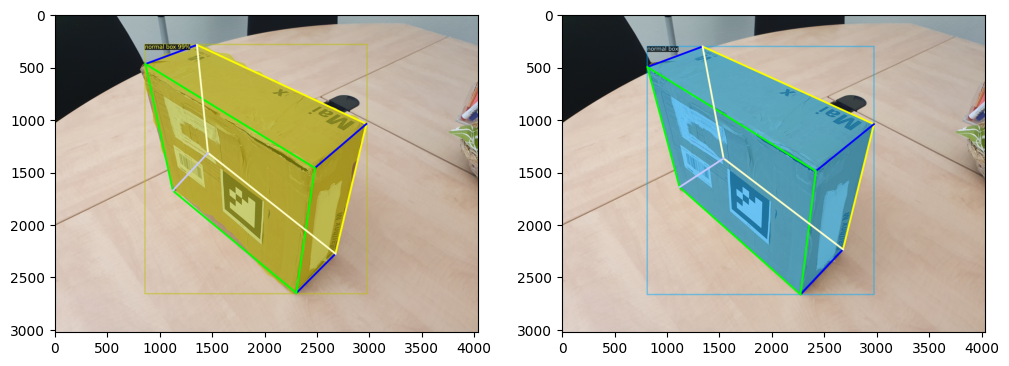

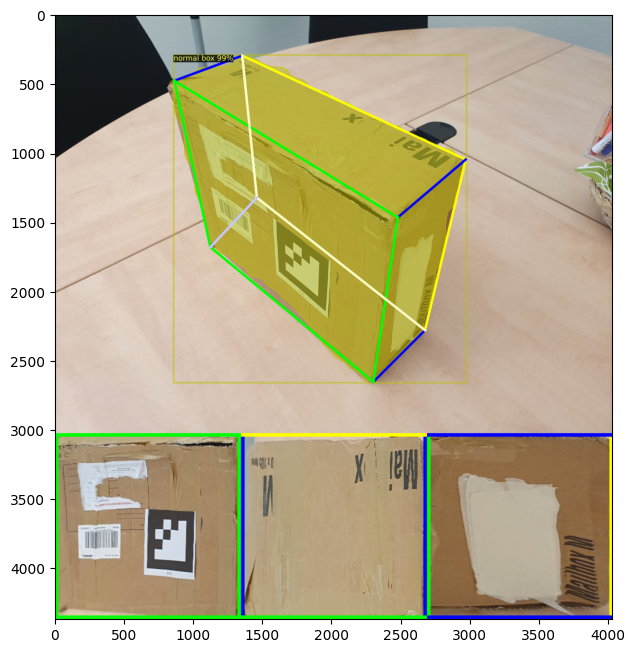

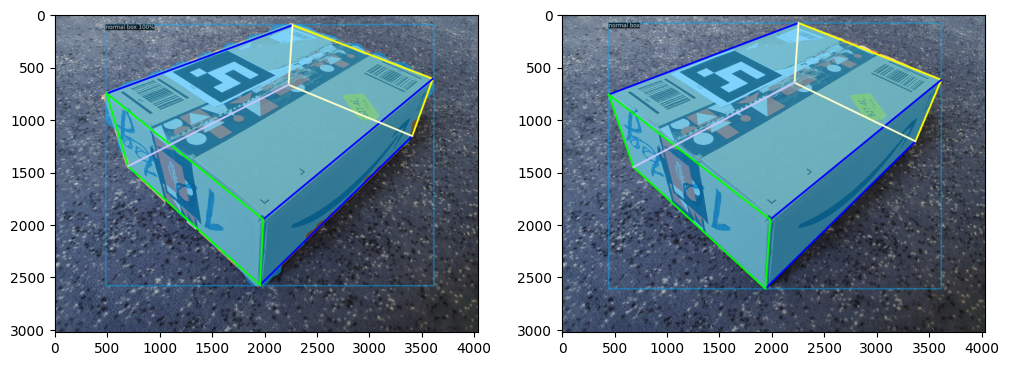

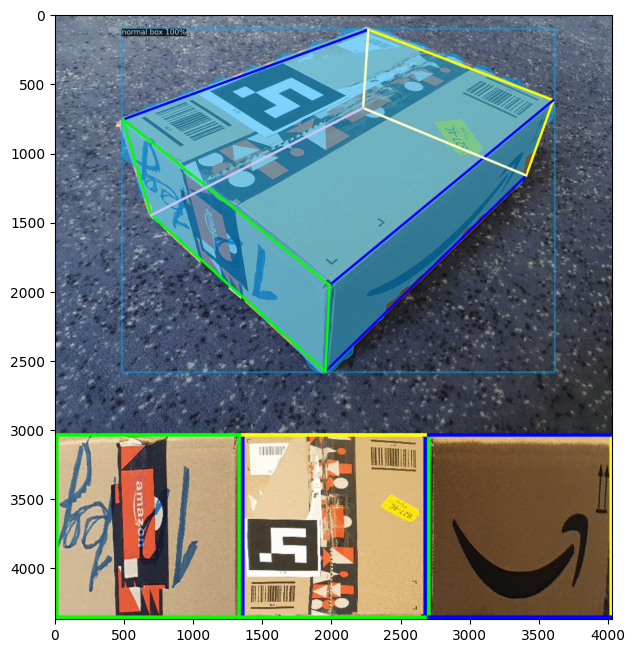

In [12]:
from detectron2.utils.visualizer import Visualizer
from src.utils.tampering_vis import visualize_parcel_side_surfaces

np.set_printoptions(suppress=True)  # https://stackoverflow.com/a/10854323
OUTPUT_PATH = base_path / "imgs"
OUTPUT_PATH.mkdir(exist_ok=True)

show_plot = True

for d in random.sample(data, 2):
    img_path = Path(d["file_name"])
    img_id = img_path.parent.name
    img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    outputs = predictor(img)
    v_pred = Visualizer(img, metadata=MetadataCatalog.get(dataset_name))
    v_gt = Visualizer(img, metadata=MetadataCatalog.get(dataset_name))
    out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_gt = v_gt.draw_dataset_dict(d)
    # Plot
    if show_plot:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(out_pred.get_image())
        axs[1].imshow(out_gt.get_image())
    gt_keypoints = [
        np.array(anno["keypoints"]).reshape(-1, 3) for anno in d.get("annotations", [])
    ]  # GT
    pred_keypoints = [
        np.array(i).reshape(-1, 3)
        for i in outputs["instances"].pred_keypoints.cpu().numpy().tolist()
    ]  # pred
    img_sidefaces = None
    for keypoints in pred_keypoints:
        if len(keypoints) > 0:
            img_sidefaces = img.copy()
            img_sidefaces = visualize_parcel_side_surfaces(
                keypoints[:, :2], img_sidefaces
            )
            img_sidefaces = np.hstack(img_sidefaces)

    if img_sidefaces is not None:
        height, width = out_pred.get_image().shape[:2]
        scaled_height = int(img_sidefaces.shape[0] * (width / img_sidefaces.shape[1]))
        img_sidefaces_scaled = cv2.resize(img_sidefaces, (width, scaled_height))
        summary = np.vstack((out_pred.get_image(), img_sidefaces_scaled))
        if show_plot:
            plt.figure()
            plt.imshow(summary)